### Time+PSD를 input으로 넣고 Time+PSD를 Loss로 설정
이때 PSD는 welch's method로 얻음
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


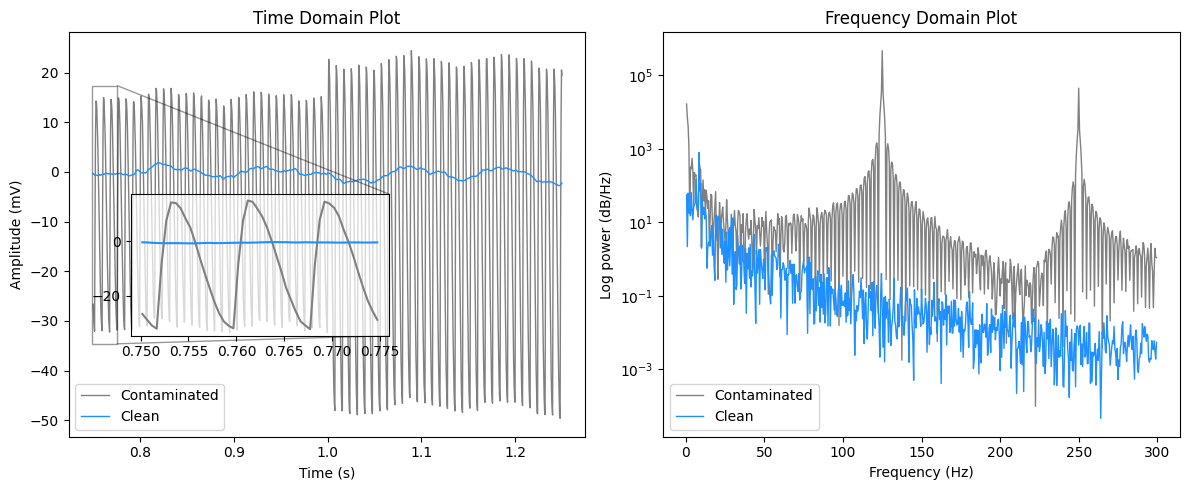

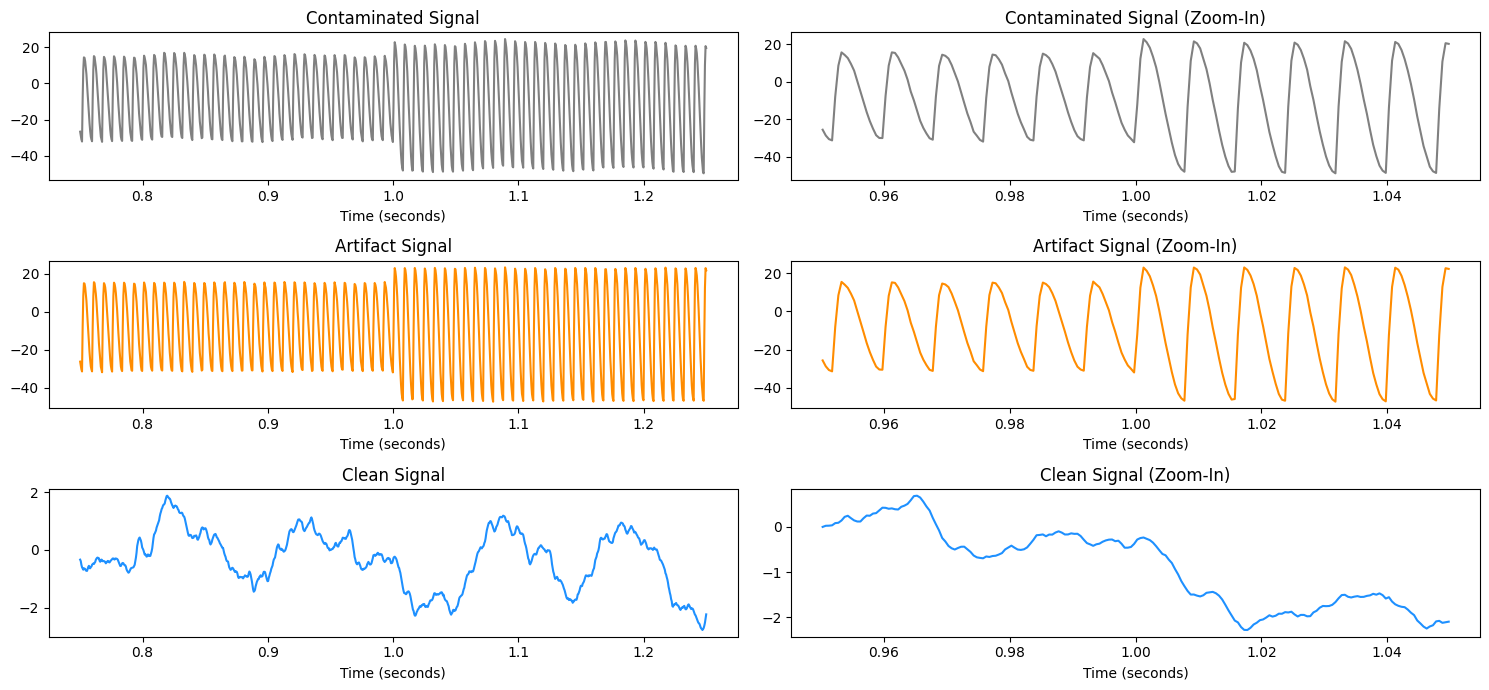

(10000, 4000)
(10000, 4000)
(10000, 4000)


In [2]:
# 데이터 load & plot
# datapath = "C:/Users/stell/OneDrive/바탕 화면/10000_data/"
datapath = "C:/Users/User/Desktop/SCH/10000_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

# Contaminated_data = Contaminated_data[0:1000]
# Clean_data = Clean_data[0:1000]
# Artifact_data = Artifact_data[0:1000]
print(Contaminated_data.shape)
print(Clean_data.shape)
print(Artifact_data.shape)

In [3]:
# Data Standard Scaling
X_time, y_time, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (10000, 4000)
y: (10000, 4000)


In [4]:
# PSD
freqs, _, _, X_psd = FFT(X_time, fs=2000, single_sided=False)
_, _, _, y_psd = FFT(y_time, fs=2000, single_sided=False)

In [5]:
# 1 - time series Data preprocessing
X1_train, X1_test, y1_train, y1_test = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X1_train shape: {X1_train.shape}\ny1_train shape: {y1_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X1_test shape: {X1_test.shape}\ny1_test shape: {y1_test.shape}")
print("-----------------------------")

train_dataset1 = TensorDataset(torch.tensor(X1_train, dtype=torch.float32), torch.tensor(y1_train, dtype=torch.float32))
test_dataset1 = TensorDataset(torch.tensor(X1_test, dtype=torch.float32), torch.tensor(y1_test, dtype=torch.float32))

train_loader1 = DataLoader(dataset=train_dataset1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(dataset=test_dataset1, batch_size=32, shuffle=False)

# 2 - psd Data preprocessing
X2_train, X2_test, y2_train, y2_test = train_test_split(X_psd, y_psd, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X2_train shape: {X2_train.shape}\ny2_train shape: {y2_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X2_test shape: {X2_test.shape}\ny2_test shape: {y2_test.shape}")
print("-----------------------------")

train_dataset2 = TensorDataset(torch.tensor(X2_train, dtype=torch.float32), torch.tensor(y2_train, dtype=torch.float32))
test_dataset2 = TensorDataset(torch.tensor(X2_test, dtype=torch.float32), torch.tensor(y2_test, dtype=torch.float32))

train_loader2 = DataLoader(dataset=train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=32, shuffle=False)

<Original>
-----------------------------
X1_train shape: (8000, 4000)
y1_train shape: (8000, 4000)
-----------------------------
X1_test shape: (2000, 4000)
y1_test shape: (2000, 4000)
-----------------------------
<Original>
-----------------------------
X2_train shape: (8000, 4000)
y2_train shape: (8000, 4000)
-----------------------------
X2_test shape: (2000, 4000)
y2_test shape: (2000, 4000)
-----------------------------


In [6]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.gelu = nn.GELU()

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.gelu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out
    
# MLP 클래스 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(0.2))
            in_size = hidden_size
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class JointSpaceModel(nn.Module):
    def __init__(self):
        super(JointSpaceModel, self).__init__()
        self.mlp_psd = MLP(input_size=4000, hidden_sizes=[128, 64], output_size=32)
        self.lstm_joint = LSTM(input_size=1, hidden_size=128, num_layers=2, output_size=1)
        self.fc_recover = nn.Linear(4032, 4000)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, time_series, psd): # time_series : B x 4000, psd : B x 4000
        psd_features = self.mlp_psd(psd) # B x 4000 -> B x 32
        joint_features = torch.cat((psd_features, time_series), dim=1) # B x 4032
        joint_features = joint_features.unsqueeze(-1) # B x 4032 -> B x 4032 x 1
        joint_space = self.dropout(self.gelu(self.lstm_joint(joint_features))) # B x 4032 x 1 -> B x 4032 x 1
        recovered_time_series = self.fc_recover(joint_space.squeeze()) # B x 4032 -> B x 4000
        return recovered_time_series

In [7]:
model = JointSpaceModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

JointSpaceModel(
  (mlp_psd): MLP(
    (network): Sequential(
      (0): Linear(in_features=4000, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (lstm_joint): LSTM(
    (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (gelu): GELU(approximate='none')
  )
  (fc_recover): Linear(in_features=4032, out_features=4000, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.2, inplace=False)
)


In [8]:
# 모델 학습
num_epochs = 500

loss_list = []

# Learning rate scheduler 초기화
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (x1, y1), (x2, y2) in zip(train_loader1, train_loader2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        
        optimizer.zero_grad()
        
        # 모델 예측
        y_pred = model(x1, x2)
        
        # 손실 계산
        loss = criterion(y_pred, y1)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x1.size(0)
    
    epoch_loss = running_loss / len(train_loader1.dataset)
    loss_list.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

    # Learning rate scheduler step
    # scheduler.step()

Epoch [1/500], Loss: 0.004464103891514241
Epoch [2/500], Loss: 0.002826004753820598
Epoch [3/500], Loss: 0.0028124483674764633
Epoch [4/500], Loss: 0.0028067324571311473
Epoch [5/500], Loss: 0.0028059343798086047
Epoch [6/500], Loss: 0.002818919688463211
Epoch [7/500], Loss: 0.0028096165489405393
Epoch [8/500], Loss: 0.0028026085020974277
Epoch [9/500], Loss: 0.002814074286259711
Epoch [10/500], Loss: 0.002807576946914196
Epoch [11/500], Loss: 0.002809148784726858
Epoch [12/500], Loss: 0.0028011222332715987
Epoch [13/500], Loss: 0.0027945435168221593
Epoch [14/500], Loss: 0.0027978585306555033
Epoch [15/500], Loss: 0.002793315733782947
Epoch [16/500], Loss: 0.002800532971508801
Epoch [17/500], Loss: 0.0028904489018023016
Epoch [18/500], Loss: 0.0028959711892530323
Epoch [19/500], Loss: 0.0029233391787856816
Epoch [20/500], Loss: 0.002407577885314822
Epoch [21/500], Loss: 0.00047340813919436185
Epoch [22/500], Loss: 0.0002720515410765074
Epoch [23/500], Loss: 0.00023745883919764311
Epoc

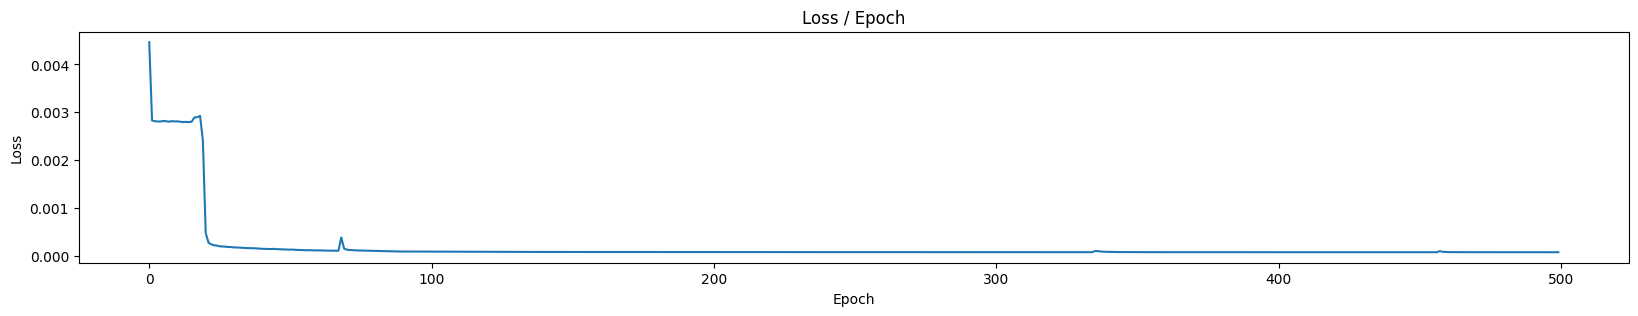

Minimal Loss: 7.310523497289978e-05 [497]



In [9]:
# Train Loss Plot
Loss_Plot(loss_list)

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for (x1, y1), (x2, y2) in zip(test_loader1, test_loader2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        
        # 모델 예측
        y_pred = model(x1, x2)
        
        # 손실 계산
        loss = criterion(y_pred, y1)
        
        test_loss += loss.item() * x1.size(0)

        Contaminated = torch.cat((Contaminated, x1.cpu().detach()), dim=0)
        Clean = torch.cat((Clean, y1.cpu().detach()), dim=0)
        SACed = torch.cat((SACed, y_pred.cpu().detach()), dim=0)

test_loss /= len(test_loader1.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0000


torch.Size([2000, 4000])


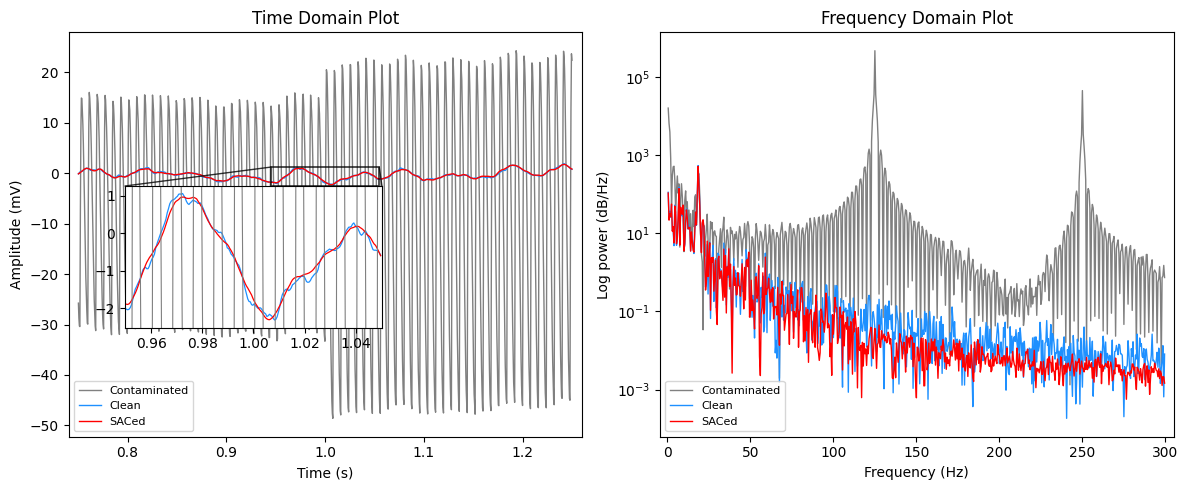

< MSE >
Time Domain MSE: 0.014614217221132045 ± 0.003184835054567892
Frequency Domain MSE: 1.5256041234152375 ± 1.144941933457421
Time + Frequency MSE: 2.4572054958745793 ± 0.5905639585337152


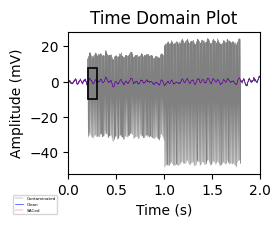

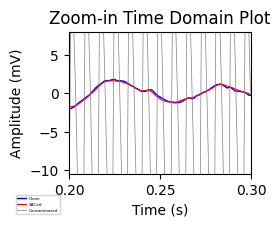

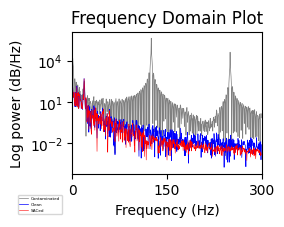

< MSE >
Time Domain MSE: 0.014614217221132045 ± 0.003184835054567892
Frequency Domain MSE: 1.5256041234152375 ± 1.144941933457421
Time + Frequency MSE: 2.4572054958745793 ± 0.5905639585337152


In [11]:
print(Contaminated.shape)

# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

save_path = '../../../result/data_10000/LSTM/'
save_title = 'LSTM_IO_time+psd'

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음
Result_Plot_paper(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음